In [1]:
# Import necessary Modules
import time
start_time = time.time()

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta

print(time.time() - start_time, 'Seconds')

37.38956356048584 Seconds


In [2]:
start_time = time.time()

# Load the cleaned csv data as DataFrame 
df = pd.read_csv('C:\Capstone2\Intermediate_data\Trimmed.csv', 
                parse_dates = ['earliest_cr_line', 'issue_d', 'last_pymnt_d', 'last_credit_pull_d'])

# drop unnecessary data
df.drop('Unnamed: 0', axis = 1, inplace = True)

#create dummy of loan status
df['loan_status_dum'] = pd.get_dummies(df.loan_status, drop_first = True)

print(time.time() - start_time, 'Seconds')

C:\Users\lekhn_000\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


116.06364130973816 Seconds


## Company performace history: 

Lending club started business in 2007 and its business took off rapidly after the club showed up in the market. One of the major indicator, the amount funded to lenders increases logarithmically over time. In 2007, the club funded couple of hundred thousands of money to the lenders, which became in the order of several millions in 2016.  

One of the great concerns the company faces is that in average 15 percent of the customers do not pay loans in time. Then the loan has to go to the collection, and the company requires to pay a recovery fee. arged off loans go to the collection, which would be finally recovered. This cost This amounts to nearly 10 percent of company investment in 

The goal of this company is to identify lenders that are likely to 

C:\Users\lekhn_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


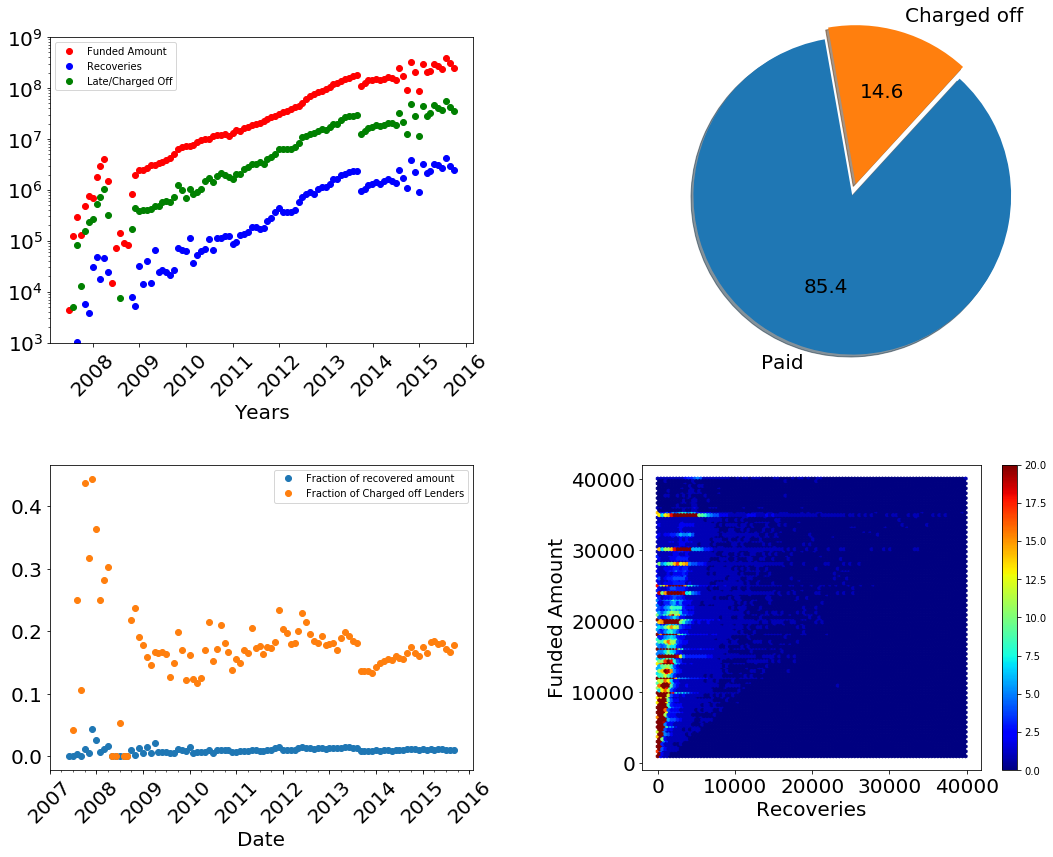

In [3]:
fig, axes = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize = [15, 12])

df_sample = df[['issue_d', 'term', 'funded_amnt', 'recoveries', 'loan_status']]

df_sample.final_d = df_sample.issue_d + pd.to_timedelta(df_sample.term, unit = 'M') 

df_sample = df_sample[df_sample.final_d < df_sample.issue_d.max()]

df_sample.index = df_sample.issue_d

df_sam =df_sample.resample('M')

plt.subplot(axes[0, 0])
plt.plot(df_sam.funded_amnt.sum(), 'ro', label = 'Funded Amount')
plt.plot(df_sam.recoveries.sum(), 'bo', label = 'Recoveries')
#axes[0, 0].tick_params(, rotation = 45)
axes[0, 0].tick_params(axis = 'x', rotation = 45, labelsize=20)
axes[0, 0].tick_params(axis = 'y', rotation = 0, labelsize=20)

###subplot II

S2 = df_sample.groupby('loan_status').count().term.plot(kind = 'pie', autopct='%.1f',startangle = 100, 
                                                        explode = (0.05, 0.05), labels = ('Paid', 'Charged off'),
                                                        shadow = True, radius = 1.3, rotatelabels = False,
                                                       fontsize=20, ax = axes[0,1])

S2.set(ylabel = '')


## subplot III
(df_sam.sum().recoveries/df_sam.sum().funded_amnt).plot(marker = 'o', ax = axes[1, 0], label = 'Fraction of recovered amount',
                                                        linewidth = 0.0)
df_sam1 = (df_sample[df_sample.loan_status == 'Current/Fully Paid']).resample('M').count()
df_sam2 = (df_sample[df_sample.loan_status != 'Current/Fully Paid']).resample('M').count()

(df_sam2.term/df_sam1.term).plot(ax = axes[1,0], linewidth = 0.0, marker = 'o', label = 'Fraction of Charged off Lenders')
axes[1, 0].legend()

axes[1, 0].tick_params(labelsize = 20)
axes[1, 0].set_xlabel('Date', fontsize = 20)
axes[1, 0].tick_params(axis = 'x', rotation = 45, labelsize=20)


df_b = df_sample.loan_status != 'Current/Fully Paid'
df_sam = df_sample[df_b]
df_sam = df_sam.resample('M')

plt.plot(df_sam.sum().funded_amnt, 'go', label = 'Late/Charged Off')

plt.semilogy()
plt.ylim(1e3, 1e9)
plt.xlabel('Years', fontsize = 20)
plt.legend()

## subplot IV
ax = plt.subplot(2,2,4)
df_sample = df[df.recoveries > 0]
plt.hexbin(df_sample.recoveries, df_sample.funded_amnt, cmap = 'jet', bins = 200, vmax = 20)
cax = plt.colorbar()

ax.set_xlabel('Recoveries', fontsize = 20)
ax.set_ylabel('Funded Amount', fontsize = 20)
ax.tick_params(axis = 'both', labelsize=20)
plt.tight_layout()

plt.subplots_adjust(hspace = 0.4, wspace = 0.4)

#plt.show()

## Predicting next year investment

C:\Users\lekhn_000\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


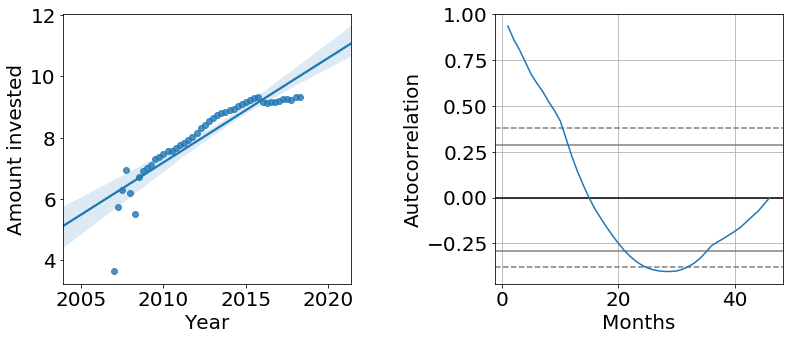

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize = [10, 5])

df_sample = df[['issue_d',  'funded_amnt', 'recoveries']]
df_sample.index = df_sample.issue_d
df_sam =df_sample.resample('3M').sum()

df_sam = df_sam[df_sam['funded_amnt'] > 0]
df_sam['amount_log'] = np.log10(df_sam.funded_amnt)
df_sam['year_of_business'] = 2007+ (df_sam.index - df_sam.index.min()).days/365

plt.subplot(position = [0.1, 0.15, 0.4, 0.75])
S1 = sns.regplot(data = df_sam, x = 'year_of_business', y = 'amount_log')
plt.xlabel('Year', fontsize =  20)
plt.ylabel('Amount invested', fontsize =  20)
plt.axis(fontsize = 20)
S1.tick_params(labelsize=20)

from pandas.plotting import autocorrelation_plot, lag_plot

S2 = autocorrelation_plot(df_sam.funded_amnt, ax = axes[0,1])
S2.set_position([0.7, 0.15, 0.4, 0.75])
S2.set_ylabel('Autocorrelation', fontsize = 20)
S2.set_xlabel('Months', fontsize = 20)
S2.tick_params(labelsize=20)


## Who are the customers?

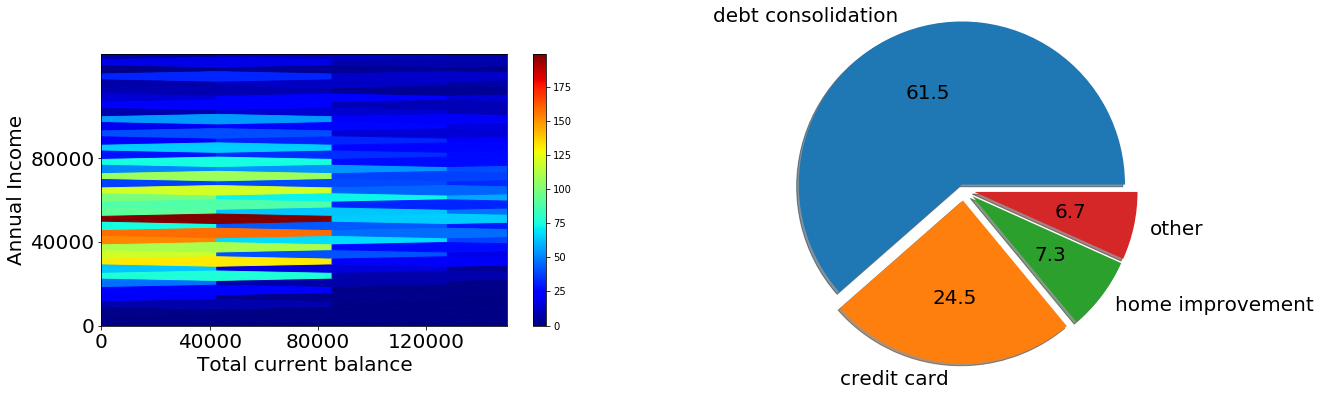

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, squeeze=False)

S1 = plt.subplot(121)
S1.figsize = (5,5)


plt.hexbin(df.tot_cur_bal, df.annual_inc, bins= 200, cmap = 'jet')
plt.ylim(0, 130000)
plt.xlim(0, 1.5e5)
plt.xticks(np.arange(0, 120001, 40000), fontsize = 20)
plt.yticks(np.arange(0, 120000, 40000), fontsize = 20)

plt.xlabel('Total current balance', fontsize = 20)
plt.ylabel('Annual Income', fontsize = 20)
plt.colorbar()


df.purpose = df.purpose.str.replace('_', ' ')
df_sample = df.groupby('purpose').count().sort_values(by = 'term', ascending = False)[:4]
S2 = df_sample.term.plot(kind = 'pie', autopct='%.1f',startangle = 0, 
                         shadow = True, radius = 1.5, explode = (0.05, 0.1, 0.1, 0.1),
                         rotatelabels = False, fontsize=20, figsize = (20,5), ax = axes[0,1])

S2.set(ylabel = '')
plt.show()

## Knowing Loan status

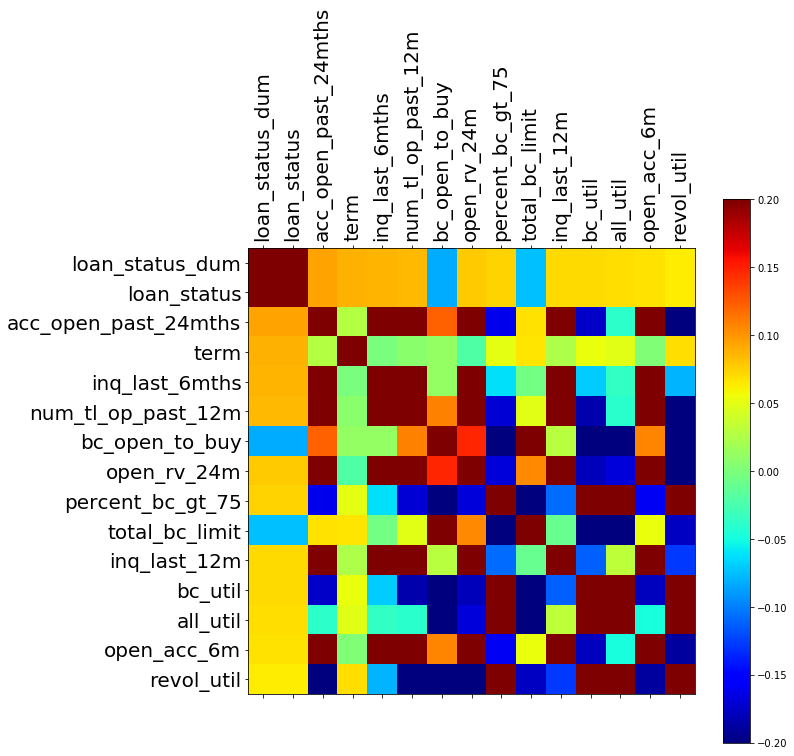

In [6]:
df_copy = df.copy(deep = True)

df_copy.drop(['last_pymnt_amnt', 'collection_recovery_fee', 'recoveries', 'out_prncp_inv', 
         'out_prncp', 'total_rec_prncp', 'int_rate', 'total_pymnt', 'total_pymnt_inv',
         'total_rec_late_fee', 'total_rec_int', 'emp_title', 'debt_settlement_flag', 
         'addr_state', 'purpose', 'delinq_amnt', 'hardship_flag', 'pymnt_plan', 
         'collections_12_mths_ex_med', 'chargeoff_within_12_mths', 'acc_now_delinq'],
         axis = 1, inplace = True)

df_copy.loan_status = pd.get_dummies(df_copy.loan_status, drop_first = True)

corr_mat = df_copy.corr()

rel_ind = list((abs(corr_mat.loan_status).\
                sort_values(ascending = False)[:15]).index)

cor_mat = corr_mat.loc[rel_ind, rel_ind]

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(cor_mat, cmap = 'jet', vmin = -0.2, vmax = 0.2)
plt.colorbar(mappable= cax)

ax.set_xticks(np.arange(0, 15, 1))
ax.set_yticks(np.arange(0, 15, 1))

ax.set_xticklabels(rel_ind, rotation = 90, fontsize = 20)
ax.set_yticklabels(rel_ind, rotation = 0, fontsize = 20)
#fig.colorbar()
plt.show()

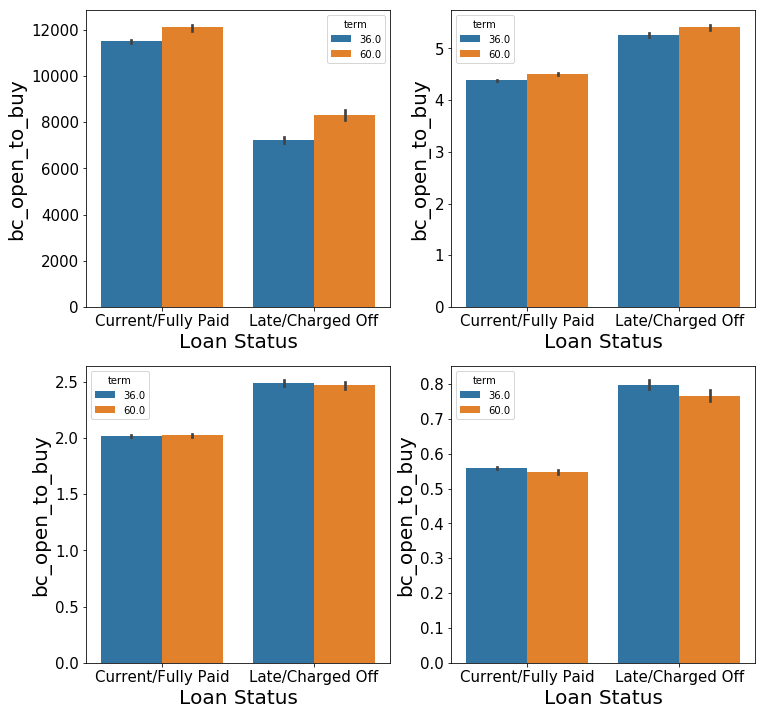

In [7]:
df_sample = df.sample(n = 800000)

fig, axes = plt.subplots(nrows = 2, ncols = 2, squeeze=False, figsize = (12, 12))

sns.barplot( x = 'loan_status', y = 'bc_open_to_buy', hue = 'term',
              ci = 99.99, data = df_sample, ax = axes[0, 0])

sns.barplot( x = 'loan_status', y = 'acc_open_past_24mths', hue = 'term',
              ci = 99.99, data = df_sample, ax = axes[0, 1])

sns.barplot( x = 'loan_status', y = 'num_tl_op_past_12m', hue = 'term',
              ci = 99.99, data = df_sample, ax = axes[1, 0])

sns.barplot( x = 'loan_status', y = 'inq_last_6mths', hue = 'term',
              ci = 99.99, data = df_sample, ax = axes[1, 1])

for i in range(2):
    for j in range(2):
        axes[i, j].tick_params(labelsize = 15)
        axes[i, j].set_xlabel('Loan Status', fontsize = 20)
        axes[i, j].set_ylabel(axes[0, 0].get_ylabel(), fontsize = 20)
        

## Distribution of Lenders?

Wall time: 1min 49s


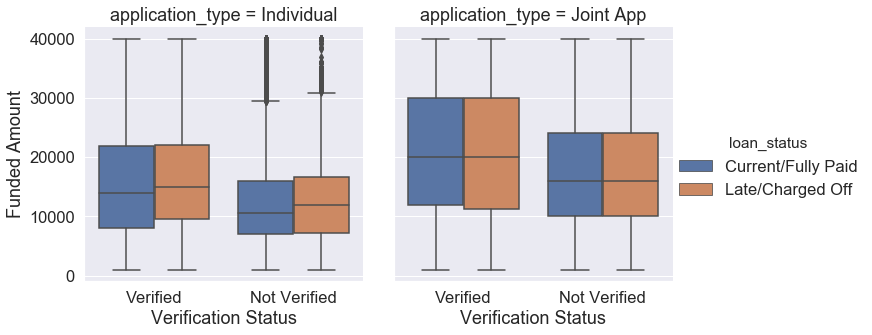

In [8]:
%%time
df_sample = df.sample(n = 800000)

sns.set(font_scale= 1.5)
g = sns.catplot(data = df_sample, x = 'verification_status', kind = 'box', 
            col = 'application_type', y = 'funded_amnt_inv', hue = 'loan_status' )

g.set_axis_labels("Verification Status", "Funded Amount")

plt.xlabel('Verification Status')

## How much does credit history matter?

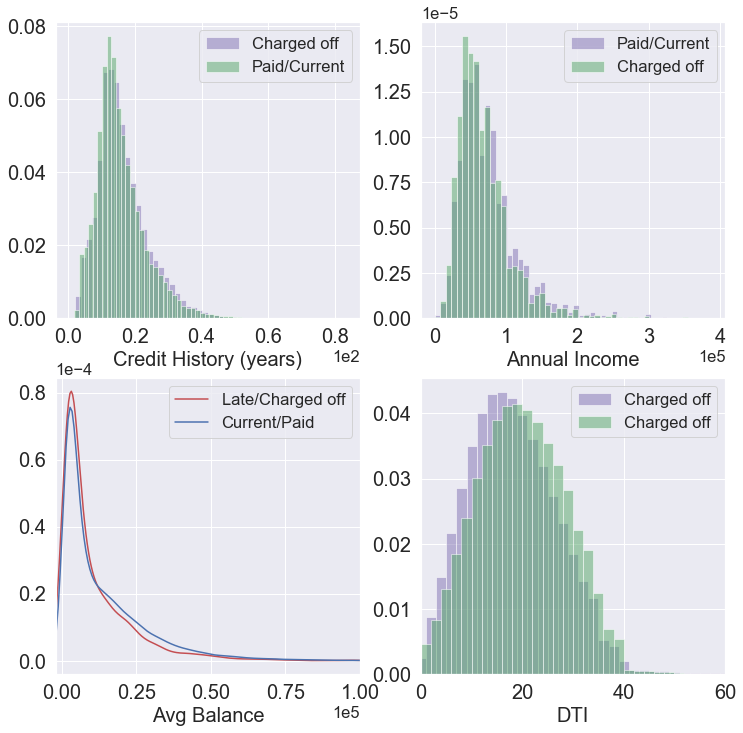

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize = (12, 12))

#subplot I

df['history'] = ((df.issue_d - df.earliest_cr_line).dt.days/365)

df_sample1 = df[df.loan_status == 'Current/Fully Paid']
S1 = df_sample1.history.hist(bins = 50, alpha = 0.5, color = 'm', ax = axes[0,0], 
                        density = True, label = 'Charged off')

df_sample2 = df[df.loan_status != 'Current/Fully Paid']
df_sample2.history.hist(bins = 50, alpha = 0.5, color = 'g', ax = S1,
                             density = True, label = 'Paid/Current')
plt.xlim(0, 55)
S1.set_xlabel('Credit History (years)', fontsize = 20)
S1.ticklabel_format(style='sci', axis='both', scilimits=(-5,0))
S1.legend()
S1.tick_params(labelsize=20)

#subplot II
S2 = df_sample1.annual_inc.hist(bins = 50, alpha = 0.5, ax = axes[0,1],
                                color = 'm', density = True, label = 'Paid/Current')

df_sample2.annual_inc.hist(bins = 50, alpha = 0.5, ax = S2,
                           color = 'g', density = True, label = 'Charged off')
plt.xlim(0, 2.5e5)
S2.legend()
S2.ticklabel_format(style='sci', axis='both', scilimits=(-5,5))
S2.set_xlabel('Annual Income', fontsize = 20)
S2.tick_params(labelsize=20)

#subplot III


dfs = df.sample(n = 80000)

df1 = dfs[dfs.loan_status != 'Current/Fully Paid']
ax = df1.avg_cur_bal.plot.kde(color = 'r', ax = axes[1,0], label = 'Late/Charged off')

df2 = dfs[dfs.loan_status == 'Current/Fully Paid']
df2.avg_cur_bal.plot.kde(color = 'b', ax = ax, label = 'Current/Paid')
ax.set_xlim(-2e3, 1e5)

ax.legend(loc = 'best')
ax.set_xlabel('Avg Balance', fontsize = 20)
ax.set_ylabel('', fontsize = 20)
ax.ticklabel_format(style='sci', axis='both', scilimits=(-6,-5))
ax.tick_params(labelsize=20)

#Subplot IV
df_sample1.dti.hist(bins = 500, alpha = 0.5, color = 'm', ax = axes[1,1],
                    density = True, label = 'Charged off')
df_sample2.dti.hist(bins = 500, alpha = 0.5, color = 'g', ax = axes[1,1],
                    density = True, label = 'Charged off')
plt.xlim(0, 60)
axes[1,1].set_xlabel('DTI', fontsize = 20)
axes[1,1].tick_params(labelsize=20)
axes[1,1].legend(loc = 'best')

plt.subplots_adjust(hspace = 0.2, wspace = 0.2)
plt.show()

## Three year term is better than five year 

In [ ]:
df_sample = df.sample(n = 800000)

sns.set(font_scale= 1.5)
g = sns.catplot(data = df_sample, x = 'term', kind = 'violin', 
                col = 'verification_status', y = 'funded_amnt_inv', hue = 'loan_status' )

g.set_axis_labels("Term (months)", "Funded Amount")

## When people stop paying

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, squeeze=False, figsize = (12, 6))

df_sample = df[(df.loan_status == 'Late/Charged Off') &
               (df.term == 36)]

duration = ((df_sample.last_pymnt_d - df_sample.issue_d).dropna().dt.days/(1*365))
duration.hist(bins = 30, density = True, ax  = axes[0,0], label = 'Term = 3 Yr')

df_sample = df[(df.loan_status == 'Late/Charged Off') &
               (df.term == 60)]

duration = ((df_sample.last_pymnt_d - df_sample.issue_d).dropna().dt.days/(1*365))
duration.hist(bins = 30, density = True, ax  = axes[0, 1], label = 'Term = 5 Yr')

for i in range(2):
    axes[0, i].set_xlabel('Time (Years)', fontsize = 20)
    axes[0, i].tick_params(labelsize=20)
    #axes[0, i].set_xlim(-0.05, 1.25)
    axes[0, i].legend()


## which loan amount is more likely pay loan

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize = [12, 6])

#subplot I
loan_amnt_copy = df['loan_amnt'].copy(deep = False)

loani = 0
step = 10000
while loani <= df.loan_amnt.max():
    cond1 = df.loan_amnt <= (loani + step)
    cond2 = df.loan_amnt > loani
    cond = cond1 & cond2
    lekh_str = str(loani) + '-' + str(loani + step)
    
    loan_amnt_copy.where(~cond, lekh_str, inplace = True)
    
    loani = loani + step

df['loan_amnt_cp'] = loan_amnt_copy

df_sample = df[['loan_amnt_cp', 'loan_status_dum', 'term', 'int_rate', 'inq_last_12m']]
ax = sns.pointplot(data = df_sample, x = 'loan_amnt_cp', y = 'loan_status_dum', 
                   hue = 'term', estimator = np.mean, ax = axes[0, 0],
                   linestyles= '--')
ax.tick_params(labelsize = 20)
ax.set_xlabel('Loan Amount', fontsize = 20)
ax.set_ylabel('Loan Status', fontsize = 20)
ax.tick_params(axis = 'x', rotation = 90, labelsize=20)

## subplot II
inq_copy = df['inq_last_12m'].copy(deep = False)

interval = [0, 1, 5, 15, 30, 68]

for i in range(len(interval) - 1):
    cond1 = df.inq_last_12m >= interval[i]
    cond2 = df.inq_last_12m < interval[i+1]
    cond = cond1 & cond2
    
    lekh_str = str(interval[i]) + '-' + str(interval[i + 1])
    inq_copy.where(~cond, lekh_str, inplace = True)
    
df['inq_cp'] = inq_copy

df_sample = df[['loan_amnt_cp', 'loan_status_dum', 'term', 'int_rate', 'inq_cp']]
ax = sns.pointplot(data = df_sample, x = 'inq_cp', y = 'loan_status_dum', 
                   hue = 'term', estimator = np.mean, ax = axes[0, 1],
                   linestyles= '--')
ax.tick_params(labelsize = 20)
ax.set_xlabel('Inquiries within a year', fontsize = 20)
ax.set_ylabel('Loan Status', fontsize = 20)
ax.set_ylim(0.05, 0.25)

ax.tick_params(axis = 'x', rotation = 90, labelsize=20)
plt.subplots_adjust(wspace = 0.4)